# Вариант 4. Васильев Максим, 6373.

## Задача 1.

### Текст задачи 

В цехах $N1$ и $N2$ предприятия производится продукт Y, который в дальнейшем используется в качестве исходного материала для производства изделий в цехе $N3$. Суммарная производительность цехов N1 и N2 зависит от вложения дополнительных средств X. При работе цехов N1 и N2 в течение одного месяца эта зависимость может быть приближённо представлена в виде функций:

- $N1: y = 5 + (x + 40)^{1/3}$
- $N2: y = 7 + (x + 30)^{1/3}$

Функции остатка средств в течении месяца:

- $N1: 0.8x$
- $N2: 0.62x$

Средства выделяемые на оба цеха в течении квартала (3 месяца), составляют 179 единиц; перераспределение производится помесячно. 

Требуется распределить средства на планируемый квартал с целью получения максимального количества продукта Y.

### Формализация задачи

Так-как количество управлений невелико, для решения задачи был выбран метод Динамического программирования.Для решения задачи выбранным методом, нужно выбрать способ описания процесса.

#### Способ описания процесса

1. Этапы   - месяца финансирования, $i = 0..2$
2. Выигрыш - суммарная производительность двух цехов, $y = 12 + (x_1 + 40)^{1/3} + (x_2 + 30)^{1/3}$, где $x_1$ - вложерние в первый цех, $x_2$ - вложение во второй цех
3. Управление - количество средств выделенное на первый цех, т.к. на второй цех будет выделена автоматически оставшаяся часть.
4. Состояние - остаток средств в течении месяца, в первом месяце это $179$

#### Описание в терминах уравнения Беллмана

$S_i$ - состояние на $i$-м этапе  
$u_i$ - управление на $i$-м этапе  
$W_i$ - условный оптимальный выигрыш на всех шагах от i-го и до последнего  
$w_i(S_i, u_i)$ - выигрыш на $i$-м этапе  
$\varphi_i(S_i, u_i)$ - изменение состояния системы на i-м шаге  

Запишем выигрыш и изменение состояния на i-м шаге:  
$w_i(S_i, u_i) = 12 + (u_i + 40)^{1/3} + (S_i - u_i + 30)^{1/3}$  
$\varphi_i(S_i, u_i) = 0.8 u_i + 0.66(S_i - u_i)$  

Тогда основное функциональное уравнение будет иметь следующий вид:

$W_i(S_i) = max(12 + (u_i + 40)^{1/3} + (S_i - u_i + 30)^{1/3} + W_{i+1}(0.66S_i + 0.14u_i))$

In [16]:
# Utility decorators 

def benchmark(func):
    # TODO: Only works right for non-recursive functions
    def decorated_function(*args, **kwargs):
        start = default_timer()
        ret = func(*args, *kwargs)
        end = default_timer()
        print(f"Execution time = {end - start}")
        return ret
    return decorated_function


def cached_function(func):
    """
    Implements fuction memoization
    """
    cache = {}
    def decorated_function(*args, **kwargs):
        key = tuple(args)
        if key not in cache:
            cache[key] = func(*args, **kwargs)
        return cache[key]
    return decorated_function, cache





In [17]:
# Dynamic programming model
# TODO: Construct plan from this
from typing import Callable, Union, Tuple, List


def precision_generator(max_value: float, precision):
    """
    Closure returning precision range generator for dynamic solver
    """
    indexes = int(max_value / precision)
    
    def precision_range(value: float):
        max_index = int((value / max_value) * indexes)
        for i in range(max_index):
            yield precision * i
    return precision_range


class DynamicSolver:
    def __init__(self,
                 state_change: Callable[[float, float], float],
                 local_profit_change: Callable[[float, float], float],
                 max_stages: int,
                 max_state: int,
                 precision: float = 0.001):
        self.state_change = state_change
        self.local_profit_change = local_profit_change
        self.max_stages = max_stages
        self.precision_range = precision_generator(max_state, precision)
    
    @cached_function
    def global_profit(self, stage: int, state: Union[int, float]) -> Tuple[float, int]:
        """Implements global profit in bellmans equation"""
        if stage >= self.max_stages:
            return (0, None)
        
        profit = [
            (
                self.local_profit_change(state, management) + self.global_profit(stage + 1, self.state_change(state, management))[0],
                management
            ) for management in self.precision_range(state)
        ]
        return max(profit, key=lambda x: x[0])
    
    global_profit, cache = cached_function(global_profit)
    
    def construct_plan(self, stage, state):
        plan = []
        for stage in range(self.max_stages):
            _, management = self.cache[(self, stage, state)]
            plan.append(management)
            state = self.state_change(state, management)
        return plan

    

local_win = lambda s, u: 12 + (u + 40) ** (1/3) + ((s - u) + 30) ** (1/3)
local_state_change = lambda s, u: 0.8 * u + 0.66 * (s - u)

cost_optimizer = DynamicSolver(local_state_change, local_win, 3, 179, 1)

max_y_product = cost_optimizer.global_profit(0, 179)
print(max_y_product)

management_plan = cost_optimizer.construct_plan(0, 179)
print(management_plan)

TypeError: 'tuple' object is not callable

In [ ]:
# Management plan check, for clarity
state = 179
profit = 0

for management in management_plan:
    profit += local_win(state, management)
    state = local_state_change(state, management)
    print(f"profit: {profit}, state: {state}")

## Задача 2.

### Текст задачи

Цех N3 выпускает продукци в виде трех изделий
TODO

### Формализация задачи

$f(x) = x_{21} + x_{31} + x_{12} + x_{22} + x_{13} + x_{33} -> max$ 

$x_{ij}, i=1..3, j=1..3$ - количество продукции i произведённое цехом j

*Ограничения по количеству продукции:*  
y1: $0.005x_{21} + 0.004x_{31} +  0.003x_{12} + 0.009x_{22} + 0.003x_{13} + 0.005x_{33} <= Y$, где Y - количество продукции полученное в прошлом пункте.  

*Ограничения по времени:*  

y2: $5 x_{21} + 8 x_{31} <= 860$  

y3: $20 x_{12} + 8 x_{22} <= 1500$  

y4: $13 x_{13} + 9 x_{33} <= 870$  

*Ограничения на отрицательность переменных:*

$x_{21} >= 0$
$x_{31} >= 0$
$x_{12} >= 0$
$x_{22} >= 0$
$x_{13} >= 0$
$x_{33} >= 0$

In [18]:
from cvxopt import matrix, solvers

c = matrix([-1 for _ in range(6)], tc='d')
G = matrix([[0.005, 0.004, 0.003, 0.009, 0.003, 0.005],
            [5, 8, 0, 0, 0, 0],
            [0, 0, 20, 8, 0, 0],
            [0, 0, 0, 0, 13, 9],
            [-1, 0, 0, 0, 0, 0],
            [0, -1, 0, 0, 0, 0],
            [0, 0, -1, 0, 0, 0],
            [0, 0, 0, -1, 0, 0],
            [0, 0, 0, 0, -1, 0],
            [0, 0, 0, 0, 0, -1]], tc='d')

h = matrix([max_y_product[0], 860, 1500, 870, 0, 0, 0, 0, 0, 0], tc='d')
solution = solvers.lp(c, G.T, h, solver='glpk')

print(f'Status: {solution["status"]}')
print(f'Objective: {-solution["primal objective"]}')
print(f'x = \n{solution["x"]}')

max_product = -solution['primal objective']
shadow_price, reduced_cost = solution['z'][:-len(c)], solution['z'][-len(c):]
print(f'Shadow price=\n{shadow_price}\nReduced cost=\n{reduced_cost}')


Status: optimal
Objective: 456.1666666666667
x = 
[ 1.72e+02]
[ 0.00e+00]
[ 0.00e+00]
[ 1.88e+02]
[ 0.00e+00]
[ 9.67e+01]

Shadow price=
[-0.00e+00]
[ 2.00e-01]
[ 1.25e-01]
[ 1.11e-01]

Reduced cost=
[-0.00e+00]
[ 6.00e-01]
[ 1.50e+00]
[-0.00e+00]
[ 4.44e-01]
[-0.00e+00]



### Выводы по решению:

1. Ресурс $Y$, производимый цехами $N1$ и $N2$ не является дефицитным.
2. Полностью загружены все группы оборудования, т.к. временной фонд в ограничениях $y2$, $y3$ и $y4$ является дефицитным ресурсом.

In [19]:
from typing import Tuple

import numpy as np


changing_intervals = {}

def availability_interval(с, G, h, constraint_index: int) -> Tuple[int, int]:
    """
    Возвращает интервал в котором можно изменять значение правой части ограничения
    до перехода к новому базисному решению.
    """
    dh = matrix([int(i == constraint_index) for i in range(len(h))], tc='d')
    solution = solvers.lp(c, G.T, h, solver='glpk')
    price = solution['z'][constraint_index]
    
    prev_z = -solution['primal objective']
    
    step = 100
    a = 1
    
    while True:
        solution_i = solvers.lp(c, G.T, h + dh * a, solver='glpk')
        
        if solution_i['status'] != 'optimal':
            return 0, 0
        
        new_z = -solution_i['primal objective']
        delta_z = new_z - prev_z 
        prev_z = new_z
        
        if a != 1:
            delta_z /= step
                
        if abs(delta_z - price) > 1e-6:
            right_border = h[constraint_index] + a
            break
        
        a += step
    
    a = 1
    
    while True:
        solution_i = solvers.lp(c, G.T, h - dh * a, solver='glpk')
        
        if solution_i['status'] != 'optimal':
            return 0, 0
        
        new_z = -solution_i['primal objective']
        delta_z = new_z - prev_z
        prev_z = new_z
        
        if abs(delta_z - price) > 1e-6:
            left_border = h[constraint_index] - a
            break
        
        a += 1
    
    return left_border, right_border


borders = {}
    
for constraint_index, price in enumerate(shadow_price):
    if price == 0:
        continue
    print(f'Sensitivity analysis for y{constraint_index + 1} constraint')
    left_border, right_border = availability_interval(c, G, h, constraint_index)
    borders[constraint_index] = (left_border, right_border)
    print(f'y{constraint_index + 1} availability interval is [{left_border}, {right_border}]')
    print()

Sensitivity analysis for y2 constraint
y2 availability interval is [859.0, 61861.0]

Sensitivity analysis for y3 constraint
y3 availability interval is [1499.0, 55801.0]

Sensitivity analysis for y4 constraint
y4 availability interval is [869.0, 110671.0]



  Parameter        Profit
0        y1    455.966667
1        y2  12656.198894
2        y3    456.041667
3        y1   7236.883509
4        y2    456.055556
5        y3  12656.144193


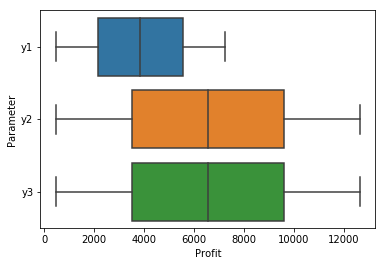

In [20]:
import seaborn as sns
import pandas as pd


def profit_values(c, G, h, constraint_index, possible_values):
    h_copy = matrix([i for i in h])
    
    for value in possible_values:
        h_copy[constraint_index] = value
        yield -solvers.lp(c, G.T, h_copy, solver='glpk')['primal objective']

results = {f'y{constraint_index}': list(profit_values(c, G, h, constraint_index, possible_values))
          for constraint_index, possible_values in borders.items()}


boxplot_df = pd.DataFrame({
    'Parameter': list(results.keys()) + list(results.keys()),
    'Profit': [value for values in results.values() for value in values],
})
print(boxplot_df)
sns.boxplot(data=boxplot_df, x='Profit', y='Parameter')


## Задача 3.

$x_{ij}$, количество перевезённого продукта i в пункт j


$f(x) = 5.1x_{11} + 7.4x_{12} + 7.6x_{13} + 5.3x_{14} + 3.0x_{15} + 5.6x_{21} + 7.4x_{22} + 4.0x_{23} + 7.9x_{24} + 6.6x_{25} + 2.2x_{31} + 4.3x_{32} + 5.7x_{33} + 5.8x_{34} + 6.6x_{35} + 5.1x_{41} + 5.3x_{42} + 3.3x_{43} + 6.7x_{44} + 6.8x_{45}$  

$x_{11} + x_{12} + x_{13} + x_{14} + x_{15} <= 0.67 \cdot prev$  
$x_{21} + x_{22} + x_{23} + x_{24} + x_{25} <= 0.67 \cdot 4400$  
$x_{31} + x_{32} + x_{33} + x_{34} + x_{35} <= 0.67 \cdot 5900$  
$x_{41} + x_{42} + x_{43} + x_{44} + x_{45} <= 0.67 \cdot 4200$  
$x_{51} + x_{52} + x_{53} + x_{54} + x_{55} <= 5579$  
$x_{11} + x_{21} + x_{31} + x_{41} + x_{51} = 1900$  
$x_{12} + x_{22} + x_{32} + x_{42} + x_{52} = 3200$  
$x_{13} + x_{23} + x_{33} + x_{43} + x_{53} = 2900$  
$x_{14} + x_{24} + x_{34} + x_{44} + x_{54} = 4100$  
$x_{15} + x_{25} + x_{35} + x_{45} + x_{55} = 3500$  
$x_{ij} >= 0$


In [21]:
import numpy as np

manufactured = [0.67 * i for i in [max_product, 4400, 5900, 4200]]
required = [1900, 3200, 2900, 4100, 3500]
delta = sum(required) - sum(manufactured)
print(f"Manufactured = {sum(manufactured)}, required = {sum(required)}, delta = {sum(required) - sum(manufactured)}")


c = matrix([5.1, 7.4, 7.6, 5.3, 0, 3.0, 5.6, 7.4, 4.0, 0, 7.9, 6.6, 2.2, 4.3, 0, 5.7, 5.8, 6.6, 5.1, 0, 5.3, 3.3, 6.7, 6.8, 0], tc='d')
G = matrix(-np.eye(25), tc='d')
h = matrix(np.zeros(25), tc='d')

A = matrix([[1, 1, 1, 1, 1,  0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0,  1, 1, 1, 1, 1,  0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  1, 1, 1, 1, 1,  0, 0, 0, 0, 0,  0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  1, 1, 1, 1, 1,  0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  1, 1, 1, 1, 1],
     
            [1, 0, 0, 0, 0,  1, 0, 0, 0, 0,  1, 0, 0, 0, 0,  1, 0, 0, 0, 0,  1, 0, 0, 0, 0],
            [0, 1, 0, 0, 0,  0, 1, 0, 0, 0,  0, 1, 0, 0, 0,  0, 1, 0, 0, 0,  0, 1, 0, 0, 0],
            [0, 0, 1, 0, 0,  0, 0, 1, 0, 0,  0, 0, 1, 0, 0,  0, 0, 1, 0, 0,  0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0,  0, 0, 0, 1, 0,  0, 0, 0, 1, 0,  0, 0, 0, 1, 0,  0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1,  0, 0, 0, 0, 1,  0, 0, 0, 0, 1,  0, 0, 0, 0, 1,  0, 0, 0, 0, 1]], tc='d')

b = matrix([0.67 * max_product,
            0.67 * 4400,
            0.67 * 5900,
            0.67 * 4200,
            delta,
     
            1900,
            3200,
            2900,
            4100,
            3500], tc='d')

transport_solution = solvers.lp(c, G.T, h, A.T, b, solver='glpk')
print(f'Minimal cost = {transport_solution["status"]}')
print(f'Plan =\n {transport_solution["x"]}')
print(f'Costs =\n {transport_solution["z"]}')

Manufactured = 10020.631666666668, required = 15600, delta = 5579.368333333332
Minimal cost = optimal
Plan =
 [ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 3.06e+02]
[ 1.90e+03]
[ 0.00e+00]
[ 0.00e+00]
[ 1.05e+03]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 2.90e+03]
[ 1.05e+03]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 2.00e+03]
[ 8.15e+02]
[ 0.00e+00]
[ 3.20e+03]
[ 0.00e+00]
[ 0.00e+00]
[ 2.38e+03]

Costs =
 [ 1.00e+00]
[ 4.10e+00]
[ 4.60e+00]
[ 2.00e-01]
[-0.00e+00]
[-0.00e+00]
[ 3.40e+00]
[ 5.50e+00]
[-0.00e+00]
[ 1.10e+00]
[ 4.60e+00]
[ 4.10e+00]
[-0.00e+00]
[-0.00e+00]
[ 8.00e-01]
[ 1.60e+00]
[ 2.50e+00]
[ 3.60e+00]
[-0.00e+00]
[-0.00e+00]
[ 1.20e+00]
[-0.00e+00]
[ 3.70e+00]
[ 1.70e+00]
[-0.00e+00]



### Рекомендации по результатам решения задачи

Так как прямая задача не имеет решения, имеется недостаток свыше 15%, была решена задача с фиктивным пунктом отправления.

В пунктах 1, 3 и 4 имеется недостаток в 1.2, 3.7 и 1.7 единиц продукции соответственно. Так как мы оптимизируем конкретно наш завод, то рекомендуется увеличить фонд рабочего времени на любом из полностью загруженных станков, так как интервал допустимости решения предыдущей задачи достаточно велик.